# Objectives

The main objective of this project is to build a model that would correctly classify individuals into 2 categories: Those that want to buy extra travel insurance and those that do not.

Our main goal is to make sure that model correctly identifies as many individuals as possible who want travel insurance, so that a sales person (or algorithm) could do an offer. 

In other words we are interested quite much in recall of positive cases (individuals that want insurance) and less in precision. Precision is not as important due to an assumption that there is no harm in offering an insurance product to a person who doesn't need that product. The customer can just say "no" without to much negative emotions.

We don't really have any reference model that we could use in order to compare with the model we will build in this project. However, we at least want our model to be better than random guessing, so we expect our recall to be more than 50% percent. We could argue that if a travel agency sales person is making a prediction, an experienced sales person might also have recall of more than 50%. 

Thus we would at least want our recall to be >=60%

# Imports

In [1]:
import functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import functions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# Suppress the specific warning
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore")

# Fetch the Data

Dataset features and labels:
- "Age" - Age Of The Customer
- "Employment Type" - The Sector In Which Customer Is Employed
- "GraduateOrNot" - Whether The Customer Is College Graduate Or Not
- "AnnualIncome" - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]
- "FamilyMembers" - Number Of Members In Customer's Family
- "ChronicDisease" - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
- "FrequentFlyer" - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].
- "EverTravelledAbroad" - Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]
- "TravelInsurance" (Label) - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.


In [2]:
original_df = pd.read_csv("TravelInsurancePrediction.csv")
original_df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [3]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


We have a mixture of categorical and numerical variables.
- Categorical: "Employment Type", "GraduateOrNot", "ChronicDisease", "FrequentFlyer", "EverTraveledAbroad"
- Numerical: "Age", "AnnualIncome"
- Numerical (Ordinal): "FamilyMembers"

It is slightly unclear what range values do "FamilyMembers" and "ChronicDisease" take, so let's check that

In [4]:
original_df.ChronicDiseases.value_counts()

ChronicDiseases
0    1435
1     552
Name: count, dtype: int64

In [5]:
original_df.FamilyMembers.value_counts().sort_index()

FamilyMembers
2     93
3    377
4    505
5    426
6    294
7    178
8     59
9     55
Name: count, dtype: int64

Alright, so our assumptions were correct that "FamilyMembers" is a ordinal feature and "ChronicDisease" is a categorical one

There is one column that is called "Unnamed". Let's see what information it has

In [6]:
index_vs_unnamed = original_df.index == original_df['Unnamed: 0']
print(f"Index and Unnamed columns are the same?: {sum(index_vs_unnamed) == original_df.index.shape[0]}")

Index and Unnamed columns are the same?: True


In [7]:
# "Unnamed: 0" column is simply an index of our dataset. We can drop it since we already have correct index
original_df.drop(columns="Unnamed: 0", inplace=True)
original_df.columns

Index(['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome',
       'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer',
       'EverTravelledAbroad', 'TravelInsurance'],
      dtype='object')

Let's check for any missing values

In [8]:
original_df.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Luckily for us there are not missing values

In [9]:
# Setting the display option to show full numbers for floats
# this is done so that "AnnualIncome" column can be shown without scientific notation
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# null values are ignored
description = original_df.describe()

print(description)


          Age  AnnualIncome  FamilyMembers  ChronicDiseases  TravelInsurance
count 1987.00       1987.00        1987.00          1987.00          1987.00
mean    29.65     932762.96           4.75             0.28             0.36
std      2.91     376855.68           1.61             0.45             0.48
min     25.00     300000.00           2.00             0.00             0.00
25%     28.00     600000.00           4.00             0.00             0.00
50%     29.00     900000.00           5.00             0.00             0.00
75%     32.00    1250000.00           6.00             1.00             1.00
max     35.00    1800000.00           9.00             1.00             1.00


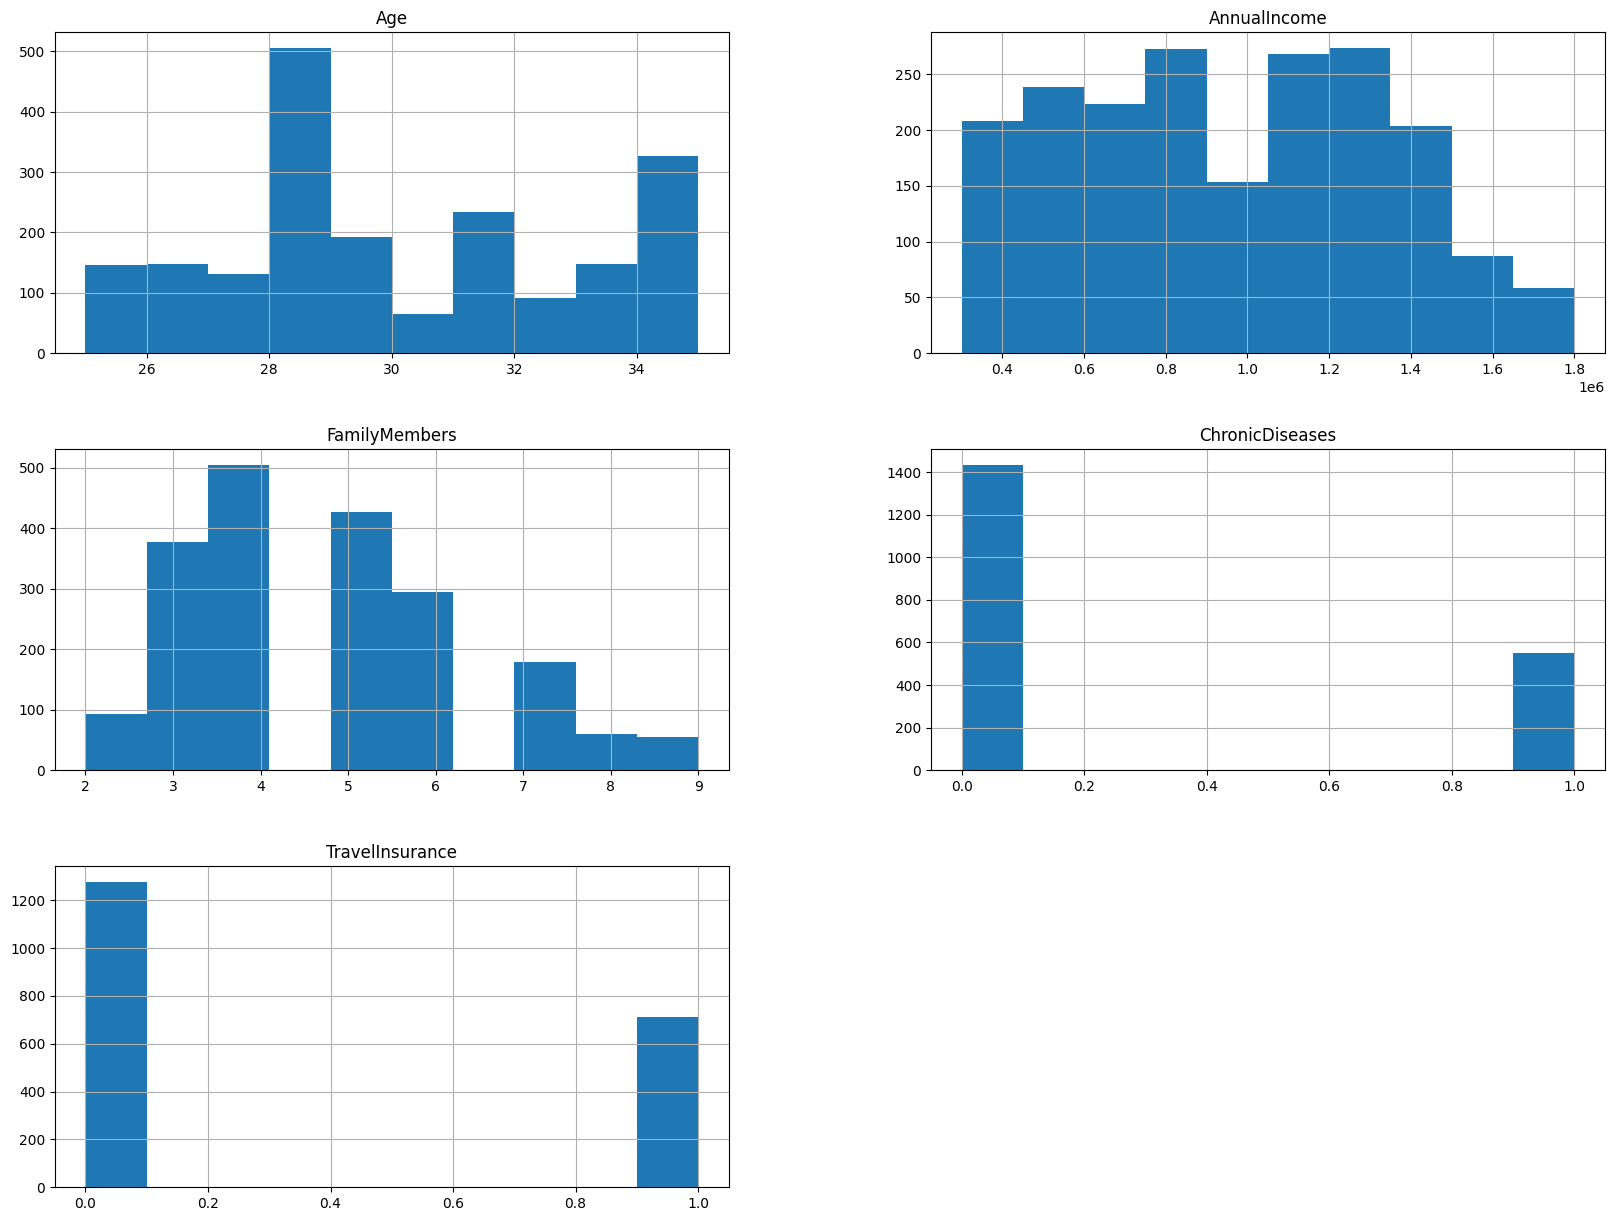

In [10]:
original_df.hist(bins=10, figsize=(20,15))
plt.show()

- Our dataset includes a rather tight customer range in terms of Age. the min age is 25 and the max is 35
- Annual income is expressed in rupees, thus, this dataset most likely includes individuals from India.
- Income mean is around 900 000 rupees, which translates to around 10 000 Euro. 
- Most of the individuals in this dataset are of age 29 and 35
- There seems to be the same proportion of individuals within different income buckets. Only more rich individuals are less represented that have income above 1.5 million rupees. 
- Family members distribution looks logical. Individuals with smaller families are less common than individuals with smaller families. 
- "TravelInsurance" label seems to be a bit unbalanced. There are more instances where individuals did not buy travel insurance (~1200) compared to individuals that bought (~800). 

# Split the data

We should split the data to train and test even before we do EDA.
If we look at the test set, we might stumble upon some seemingly interesting patterns in the test data that could lead us to select a particular kind of Machine Learning model. This might result into models that are too optimistic, and we will launch a system that will not perform as well as expected. 

In other words, we want to avoid "data snooping" bias.

In [11]:
train_set, test_set = train_test_split(original_df, test_size=0.2, random_state=1)
print(len(test_set))
print(len(train_set))

398
1589


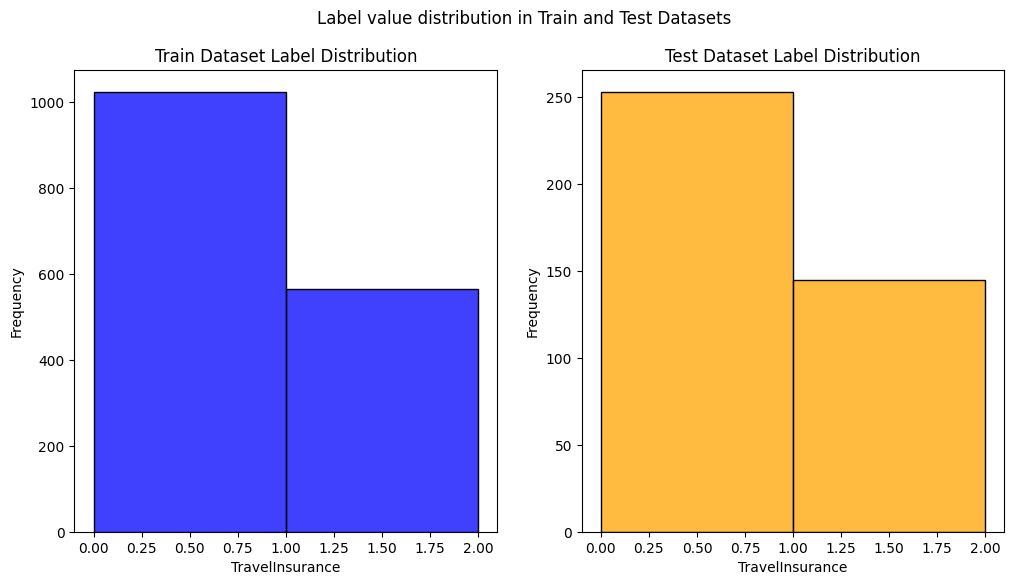

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for the train dataset
sns.histplot(train_set['TravelInsurance'], bins=[0, 1, 2], kde=False, color='blue', ax=axes[0])
axes[0].set_title('Train Dataset Label Distribution')
axes[0].set_xlabel('TravelInsurance')
axes[0].set_ylabel('Frequency')

# Plot histogram for the test dataset
sns.histplot(test_set['TravelInsurance'], bins=[0, 1, 2], kde=False, color='orange', ax=axes[1])
axes[1].set_title('Test Dataset Label Distribution')
axes[1].set_xlabel('TravelInsurance')
axes[1].set_ylabel('Frequency')

plt.suptitle('Label value distribution in Train and Test Datasets')
plt.show()


Both train and test sets have same proportion of TravelInsurance (our label) value distribution

# EDA

In [13]:
# Make copy not to harm the original train dataset
travel_eda = train_set.copy()

### Does family size affect the willingness to take travel insurance?

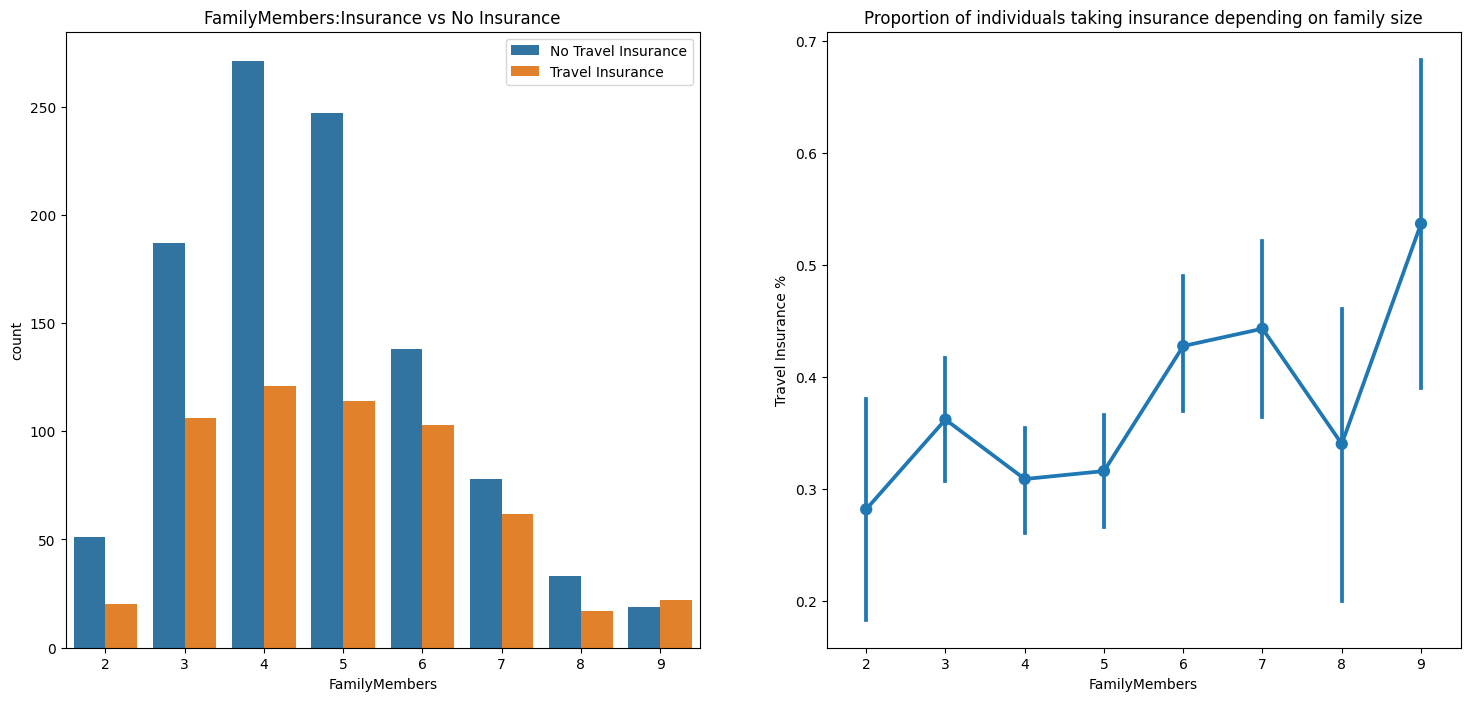

In [14]:
figure, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot(x='FamilyMembers',hue='TravelInsurance',data=travel_eda ,ax=ax[0])
ax[0].set_title('FamilyMembers:Insurance vs No Insurance')
ax[0].legend(labels=['No Travel Insurance', 'Travel Insurance'])

sns.pointplot(x='FamilyMembers', y='TravelInsurance', data=travel_eda , ax=ax[1])
ax[1].set_title('Proportion of individuals taking insurance depending on family size')
ax[1].set_ylabel("Travel Insurance %")
plt.show()


There seems to be an upward trend. Meaning that individuals with bigger families tend to take travel insurance more frequently.   

### Does employment type affect the willingness to take travel insurance?

In [15]:
travel_eda['Employment Type'].value_counts()

Employment Type
Private Sector/Self Employed    1126
Government Sector                463
Name: count, dtype: int64

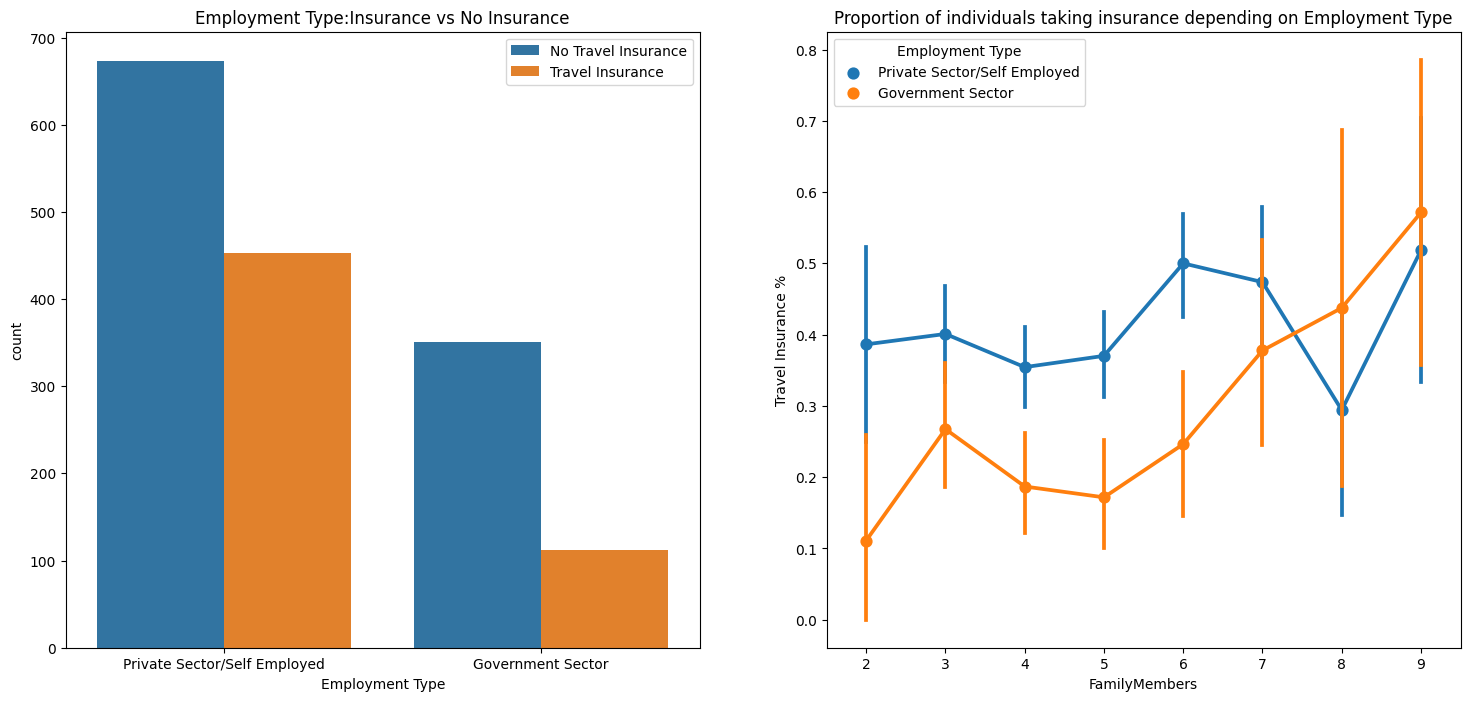

In [16]:
figure, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot(x='Employment Type',hue='TravelInsurance',data=travel_eda ,ax=ax[0])
ax[0].set_title('Employment Type:Insurance vs No Insurance')
ax[0].legend(labels=['No Travel Insurance', 'Travel Insurance'])

sns.pointplot(x='FamilyMembers', y='TravelInsurance', hue='Employment Type', data=travel_eda , ax=ax[1])
ax[1].set_title('Proportion of individuals taking insurance depending on Employment Type')
ax[1].set_ylabel("Travel Insurance %")
plt.show()


It seems like individuals that work in a Government sector feels more safe when traveling and tend to take less travel insurance. We can also see that regardless where individuals work, family size does similarly influence the choice for travel insurance. 

### Does age affect the choice of travel insurance?

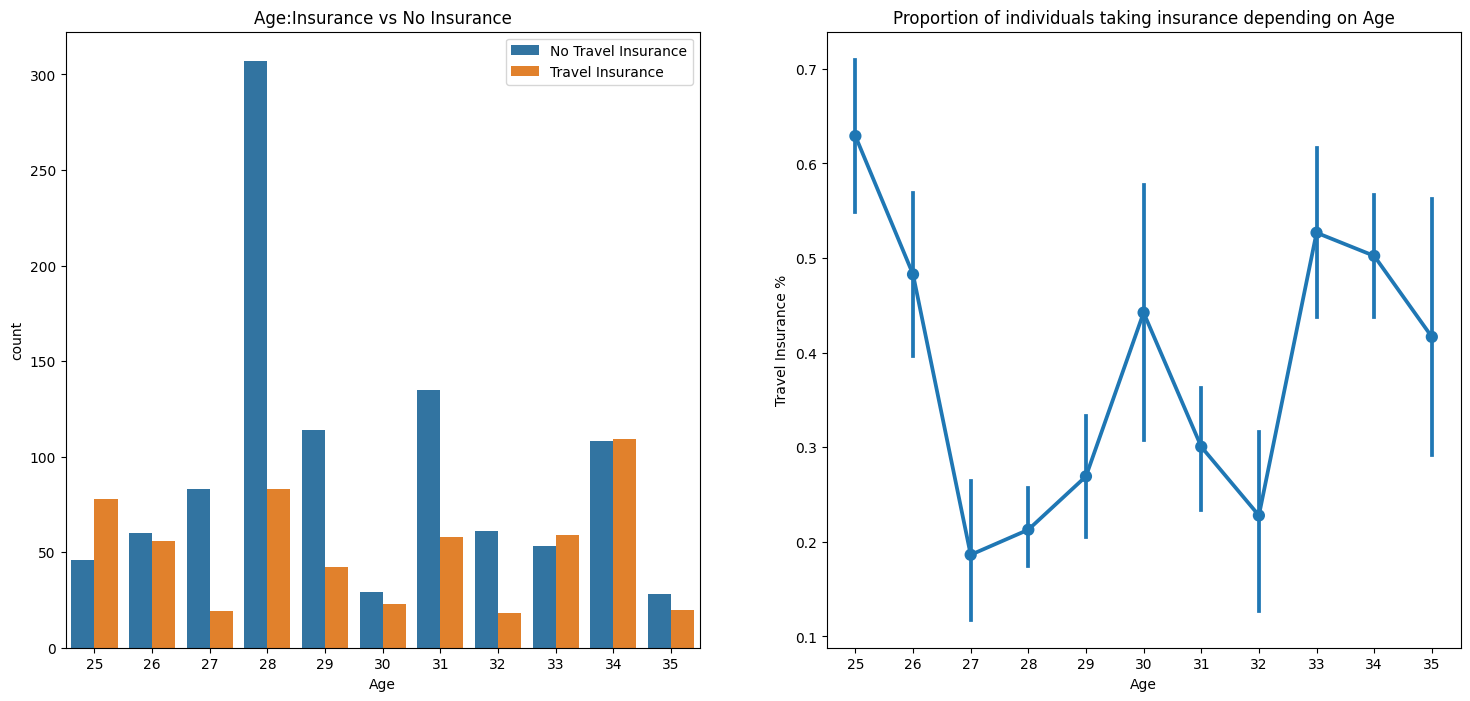

In [17]:
figure, ax = plt.subplots(1, 2, figsize=(18,8))

sns.countplot(x='Age', hue='TravelInsurance', data=travel_eda, ax=ax[0])
ax[0].set_title('Age:Insurance vs No Insurance')
ax[0].legend(labels=['No Travel Insurance', 'Travel Insurance'])

sns.pointplot(x='Age', y='TravelInsurance', data=travel_eda , ax=ax[1])
ax[1].set_title('Proportion of individuals taking insurance depending on Age')
ax[1].set_ylabel("Travel Insurance %")

plt.show()

These are quite interesting results. 
- We see that individuals aged 25-26 take insurance at about 50% rate. 
- Then the situation changes significantly for ages 27-32 where we observe a reluctance to take travel insurance. Only about 30% of individuals in this age groups take travel insurance. (age 30 is an exception, however, this age is not that well represented in this dataset) 
- Lastly, for ages 33-35, situation looks similar as for ages 25-26, meaning that about 50% of individuals take travel insurance.

It would be interesting to observe if other factors (on top of age factor) play a role for decision to take travel insurance.


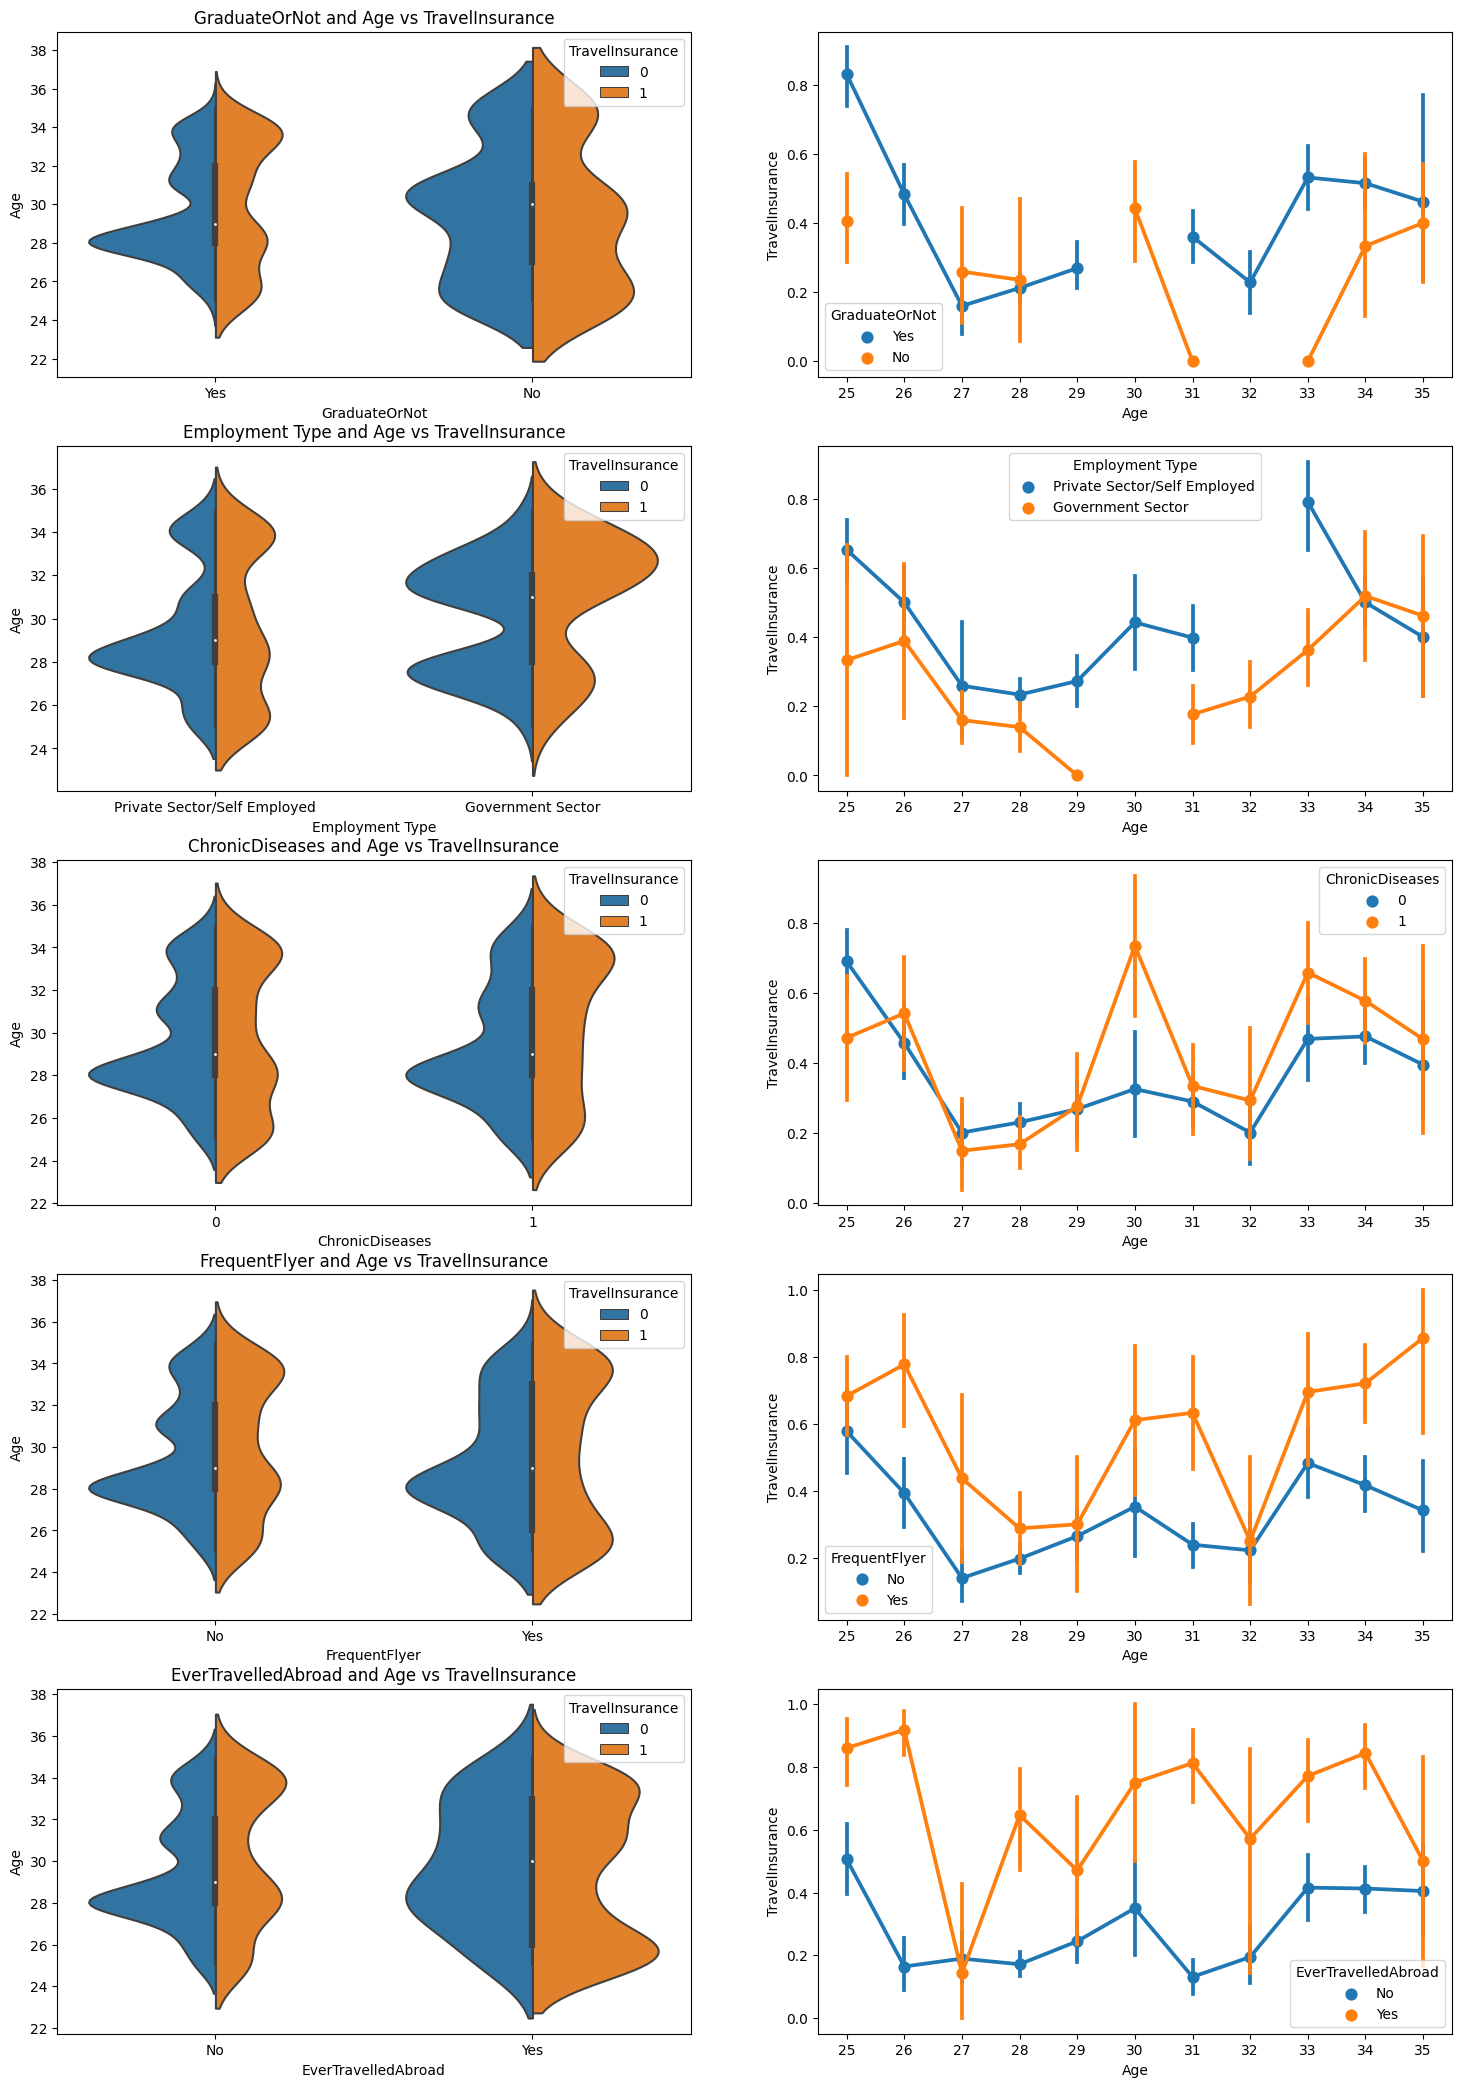

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(18, 26))

# sns.violinplot(y="Age", x="TravelInsurance", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[0, 0])
# ax[0, 0].set_title('Age vs TravelInsurance')

sns.violinplot(x="GraduateOrNot", y="Age", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[0, 0])
ax[0, 0].set_title('GraduateOrNot and Age vs TravelInsurance')
sns.pointplot(x='Age', y='TravelInsurance', hue="GraduateOrNot", data=travel_eda, ax=ax[0, 1])

sns.violinplot(x="Employment Type", y="Age", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[1, 0], 
               legend=False)
ax[1, 0].set_title('Employment Type and Age vs TravelInsurance')
sns.pointplot(x='Age', y='TravelInsurance', hue="Employment Type", data=travel_eda, ax=ax[1, 1])

sns.violinplot(x="ChronicDiseases", y="Age", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[2, 0])
ax[2, 0].set_title('ChronicDiseases and Age vs TravelInsurance')
sns.pointplot(x='Age', y='TravelInsurance', hue="ChronicDiseases", data=travel_eda, ax=ax[2, 1])

sns.violinplot(x="FrequentFlyer", y="Age", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[3, 0], 
               legend=False)
ax[3, 0].set_title('FrequentFlyer and Age vs TravelInsurance')
sns.pointplot(x='Age', y='TravelInsurance', hue="FrequentFlyer", data=travel_eda, ax=ax[3, 1])

sns.violinplot(x="EverTravelledAbroad", y="Age", hue="TravelInsurance", data=travel_eda, split=True, ax=ax[4, 0])
ax[4, 0].set_title('EverTravelledAbroad and Age vs TravelInsurance')
sns.pointplot(x='Age', y='TravelInsurance', hue="EverTravelledAbroad", data=travel_eda, ax=ax[4, 1])

plt.show()

Above plots reveal some interesting details:
- We get additional confirmation that individuals who work governmental jobs tend to take less travel insurance across all age groups
- There is a slightly higher likelihood for individuals with chronic diseases to take on more insurance after age of 30. 
- It looks like individuals who travel a lot and specially abroad, due take on much more travel insurance. This is especially true for youngest individuals (age 25-26) and individuals aged 30-32.   

### How does annual income influence travel insurance decision

In [19]:
print('Highest Income is:', travel_eda['AnnualIncome'].max())
print('Lowest Income is:', travel_eda['AnnualIncome'].min())
print('Average Income is:', travel_eda['AnnualIncome'].mean())

Highest Income is: 1800000
Lowest Income is: 300000
Average Income is: 937696.6645689113


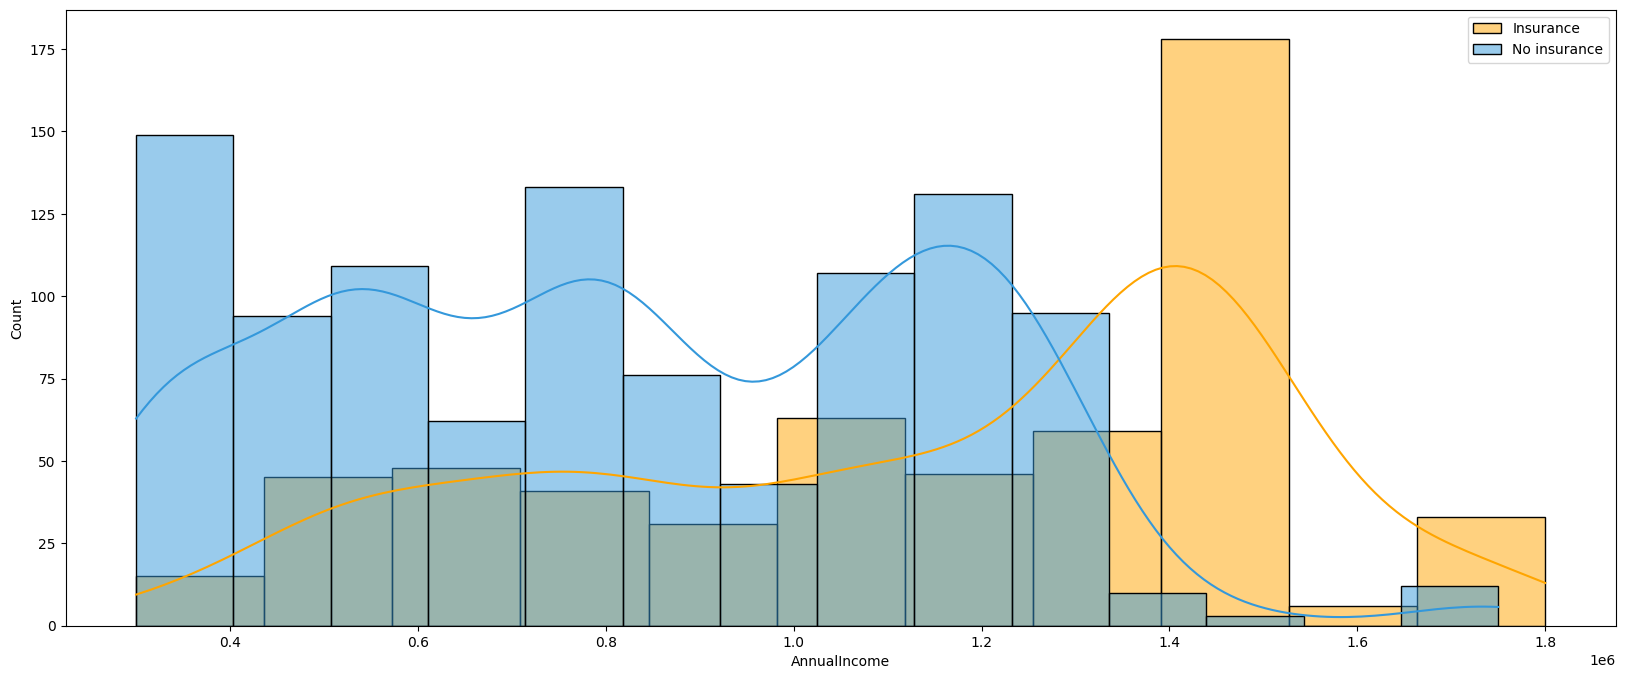

In [20]:
figure, ax = plt.subplots(1, 1, figsize=(20,8))

sns.histplot(travel_eda[travel_eda['TravelInsurance']==1].AnnualIncome, kde=True, 
             color='orange', label='Insurance')
sns.histplot(travel_eda[travel_eda['TravelInsurance']==0].AnnualIncome, kde=True, 
             color="#3498db", label='No insurance')

plt.legend()
plt.show()

In general there seems to be a trend that individuals slowly but surely tend take on more travel insurance as their income rises. It is really visible once income goes above 1.4 million rupees. It could also mean that individuals at this income level and above feel that they have enough money to spend on extra services like travel insurance. 

Observations in a Nutshell for all features:
FamilyMembers: individuals with bigger families tend to take travel insurance more frequently.

Employment Type: Government sector feels more safe when traveling and tend to take less travel insurance

Age: 25-26 and 33-35 take more insurance, while 27-32 take less

EverTravelledAbroad: Individuals that travel abroad shows clear preference for travel insurance

FrequentFlyer: Individuals that travel alot shows tendency to take on more travel insurance

AnnualIncome: Individuals with higher income prefer to take travel insurance more frequently specially if their income is at around 1.4 million and above.

### Correlation Between The Features

In [21]:
travel_eda.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
406,28,Private Sector/Self Employed,Yes,1200000,9,0,No,No,1
30,30,Private Sector/Self Employed,No,550000,6,0,Yes,Yes,0
1147,26,Private Sector/Self Employed,Yes,1500000,3,0,Yes,Yes,1
1936,33,Private Sector/Self Employed,Yes,1500000,7,0,Yes,Yes,1
421,28,Government Sector,Yes,300000,4,0,No,No,0


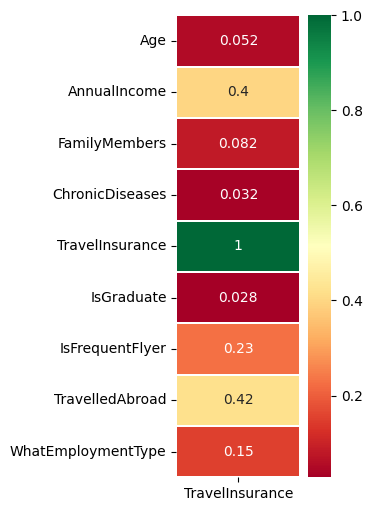

In [22]:
# Amend columns to numeric values so we can check the corrections between features
travel_eda['IsGraduate'] = travel_eda['GraduateOrNot'].map({'Yes': 1, 'No': 0})
travel_eda['IsFrequentFlyer'] = travel_eda['FrequentFlyer'].map({'Yes': 1, 'No': 0})
travel_eda['TravelledAbroad'] = travel_eda['EverTravelledAbroad'].map({'Yes': 1, 'No': 0})
travel_eda['WhatEmploymentType'] = travel_eda['Employment Type'].map({'Private Sector/Self Employed': 1, 
                                                                                      'Government Sector': 0})
travel_eda_corr = travel_eda.drop(columns=['GraduateOrNot', 'FrequentFlyer', 
                                              'EverTravelledAbroad', 'Employment Type'])

correlation_matrix = travel_eda_corr.corr()

# Extract the correlation values for the target variable
target_correlations = correlation_matrix['TravelInsurance']

sns.heatmap(target_correlations.to_frame(), annot=True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(2, 6)
plt.show()


From this correlation matrix we observe that some features are mildly correlated with our target variable. These features are: "AnnualIncome", "TraveledAbroad". And there are some week correlated ones: "IsFrequentFlyer" and "EmploymentType". There results are for the most part aligned with the results we saw earlier except for the "FamilyMembers" feature. This one has no correlation to our target variable.

# Feature Engineering

### Convert Age to age bands

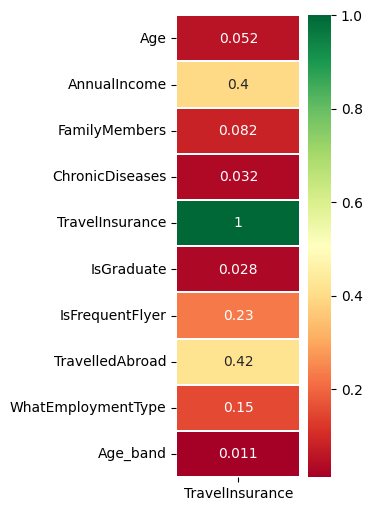

In [23]:
travel_eda_corr['Age_band']=0
travel_eda_corr.loc[travel_eda_corr['Age']<=26,'Age_band']=0
travel_eda_corr.loc[(travel_eda_corr['Age']>=27)&(travel_eda_corr['Age']<=32),'Age_band']=1
travel_eda_corr.loc[travel_eda_corr['Age']>=33,'Age_band']=2

correlation_matrix = travel_eda_corr.corr()

# Extract the correlation values for the target variable
target_correlations = correlation_matrix['TravelInsurance']

sns.heatmap(target_correlations.to_frame(), annot=True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(2, 6)
plt.show()


It seems that our "Age_band" feature is even less correlated than the original feature. Thus, we will not use it further

### Convert Family members to a category

In [24]:
travel_eda_corr['FamilySizeBand']=pd.qcut(travel_eda_corr['FamilyMembers'], 4)
travel_eda_corr.groupby(['FamilySizeBand'])['TravelInsurance'].mean().to_frame().style.background_gradient(cmap='summer_r')

,TravelInsurance
FamilySizeBand,
"(1.999, 4.0]",0.326720
"(4.0, 5.0]",0.315789
"(5.0, 6.0]",0.427386
"(6.0, 9.0]",0.437229


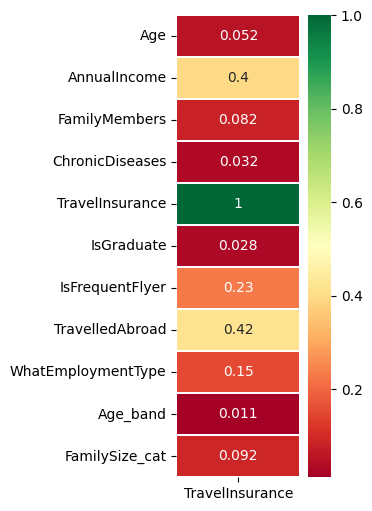

In [25]:
travel_eda_corr['FamilySize_cat']=0
travel_eda_corr.loc[travel_eda_corr['FamilyMembers']<=4.0,'FamilySize_cat']=0
travel_eda_corr.loc[(travel_eda_corr['FamilyMembers']>4.0)&(travel_eda_corr['FamilyMembers']<=5.0),'FamilySize_cat']=1
travel_eda_corr.loc[(travel_eda_corr['FamilyMembers']>5.0)&(travel_eda_corr['FamilyMembers']<=6.0),'FamilySize_cat']=2
travel_eda_corr.loc[(travel_eda_corr['FamilyMembers']>6.0),'FamilySize_cat']=3

travel_eda_corr.drop(columns=['FamilySizeBand'], inplace=True)

correlation_matrix = travel_eda_corr.corr()
# Extract the correlation values for the target variable
target_correlations = correlation_matrix['TravelInsurance']

sns.heatmap(target_correlations.to_frame(), annot=True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(2, 6)
plt.show()


New "FamilySize_cat" feature has just a slightly better correlation than original feature. We can then keep this new feature and drop the other one

### Convert Annual Income to category

In [26]:
travel_eda_corr['AnnualIncome_Band']=pd.qcut(travel_eda_corr['AnnualIncome'], 4)
travel_eda_corr.groupby(['AnnualIncome_Band'])['TravelInsurance'].mean().to_frame().style.background_gradient(cmap='summer_r')

,TravelInsurance
AnnualIncome_Band,
"(299999.999, 600000.0]",0.175644
"(600000.0, 900000.0]",0.269542
"(900000.0, 1250000.0]",0.257336
"(1250000.0, 1800000.0]",0.793103


In [27]:

bins = [0, 600000.0, 900000.0, 1250000.0, 1800000.0]
labels = [0, 1, 2, 3]

# Create a new column 'Category' based on the intervals
travel_eda_corr['AnnualIncome_cat'] = pd.cut(travel_eda_corr['AnnualIncome_Band'].apply(lambda x: x.mid), 
                                             bins=bins, 
                                             labels=labels, 
                                             include_lowest=True)

travel_eda_corr.head()



,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,IsGraduate,IsFrequentFlyer,TravelledAbroad,WhatEmploymentType,Age_band,FamilySize_cat,AnnualIncome_Band,AnnualIncome_cat
406,28,1200000,9,0,1,1,0,0,1,1,3,"(900000.0, 1250000.0]",2
30,30,550000,6,0,0,0,1,1,1,1,2,"(299999.999, 600000.0]",0
1147,26,1500000,3,0,1,1,1,1,1,0,0,"(1250000.0, 1800000.0]",3
1936,33,1500000,7,0,1,1,1,1,1,2,3,"(1250000.0, 1800000.0]",3
421,28,300000,4,0,0,1,0,0,0,1,0,"(299999.999, 600000.0]",0


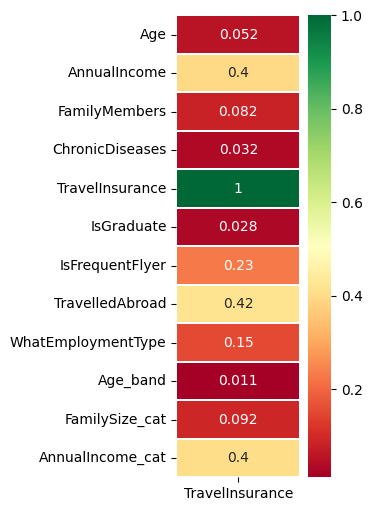

In [28]:
travel_eda_corr.drop(columns=['AnnualIncome_Band'], inplace=True)

correlation_matrix = travel_eda_corr.corr()
# Extract the correlation values for the target variable
target_correlations = correlation_matrix['TravelInsurance']

sns.heatmap(target_correlations.to_frame(), annot=True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(2, 6)
plt.show()

New "AnnualIncome_cat" feature doesn't really change the correlation situation. 

# Prepare the Data for Modeling

In [29]:
train_set.head(2)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
406,28,Private Sector/Self Employed,Yes,1200000,9,0,No,No,1
30,30,Private Sector/Self Employed,No,550000,6,0,Yes,Yes,0


### Data Cleaning

Our data had no missing values, however, we can still check for some strange data points or outliers that could impact our models

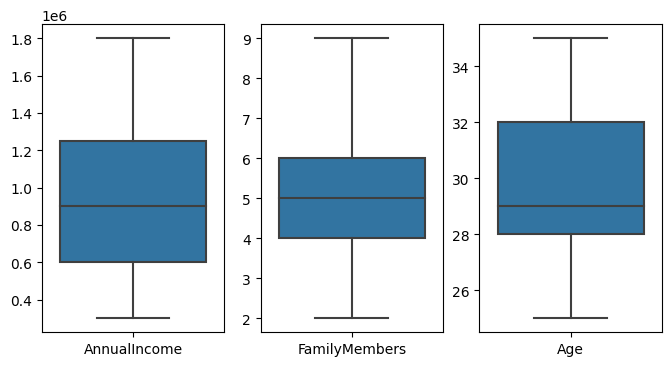

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
sns.boxplot(train_set[['AnnualIncome']], ax=ax[0])
sns.boxplot(train_set[['FamilyMembers']], ax=ax[1])
sns.boxplot(train_set[['Age']], ax=ax[2])

plt.show()

There seems to be no outliers or strange data points in our numerical variables, thus, we proceed further will all the data we have

### Transformation Pipelines

In [31]:
train_set_cat = train_set[['Employment Type', 'GraduateOrNot', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad']]
train_set_num = train_set[['Age', 'AnnualIncome']]
train_set_ord = train_set[['FamilyMembers']]
train_set_cat.head(2)

,Employment Type,GraduateOrNot,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
406,Private Sector/Self Employed,Yes,0,No,No
30,Private Sector/Self Employed,No,0,Yes,Yes


In [32]:
# Custom Transformer to engineer "FamilySize_cat" feature
class FamilySizeAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        X['FamilySize_cat'] = 0
        X.loc[X['FamilyMembers'] <= 4.0,'FamilySize_cat']=0
        X.loc[(X['FamilyMembers'] > 4.0) & (X['FamilyMembers'] <= 5.0),'FamilySize_cat'] = 1
        X.loc[(X['FamilyMembers'] > 5.0) & (X['FamilyMembers'] <= 6.0),'FamilySize_cat'] = 2
        X.loc[(X['FamilyMembers'] > 6.0),'FamilySize_cat'] = 3
        X = X.drop('FamilyMembers', axis=1)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['FamilySize_cat']


In [33]:
# Custom Transformer to engineer "AnnualIncome_cat" feature
class AnnualIncomeCatAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return 
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        X['AnnualIncome_Band'] = pd.qcut(X['AnnualIncome'], 4)
        bins = [0, 600000.0, 900000.0, 1250000.0, 1800000.0]
        labels = [0, 1, 2, 3]

        # Create a new column 'Category' based on the intervals
        X['AnnualIncome_cat'] = pd.cut(X['AnnualIncome_Band'].apply(lambda x: x.mid), 
                                                    bins=bins, 
                                                    labels=labels, 
                                                    include_lowest=True)
        X = X.drop('AnnualIncome_Band', axis=1)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['Age', 'AnnualIncome', 'AnnualIncome_cat']
        

In [34]:
# full pipeline to transform train set
full_pipeline = ColumnTransformer([
        ("ord", FamilySizeAttributeAdder(), train_set_ord.columns), # fit didn't do anything only transform does stuff
        ("cat", OneHotEncoder(sparse=False, drop='first'), train_set_cat.columns),
        ("income_cat", AnnualIncomeCatAdder(), train_set_num.columns),
        ("scale", StandardScaler(), train_set_num.columns),
    ], remainder='passthrough')

transformed_train_set = full_pipeline.fit_transform(train_set)

In [35]:
# Get the column names after each transformation
column_names = full_pipeline.get_feature_names_out()

# Create a DataFrame with the transformed data and column names
df_transformed_train_set = pd.DataFrame(transformed_train_set, columns=column_names)

In [36]:
df_transformed_train_set.head(2)

,ord__FamilySize_cat,cat__Employment Type_Private Sector/Self Employed,cat__GraduateOrNot_Yes,cat__ChronicDiseases_1,cat__FrequentFlyer_Yes,cat__EverTravelledAbroad_Yes,income_cat__Age,income_cat__AnnualIncome,income_cat__AnnualIncome_cat,scale__Age,scale__AnnualIncome,remainder__TravelInsurance
0,3.00,1.00,1.00,0.00,0.00,0.00,28.00,1200000.00,2.00,-0.57,0.70,1.00
1,2.00,1.00,0.00,0.00,1.00,1.00,30.00,550000.00,0.00,0.11,-1.03,0.00


In [37]:
# Remove the common prefix "text__" from all column names except for "scale__"
df_transformed_train_set.columns = df_transformed_train_set.columns.str.replace('ord__', '')
df_transformed_train_set.columns = df_transformed_train_set.columns.str.replace('cat__', '')
df_transformed_train_set.columns = df_transformed_train_set.columns.str.replace('income_', '')
df_transformed_train_set.columns = df_transformed_train_set.columns.str.replace('remainder__', '')


In [38]:
df_transformed_train_set.head(2)

,FamilySize_cat,Employment Type_Private Sector/Self Employed,GraduateOrNot_Yes,ChronicDiseases_1,FrequentFlyer_Yes,EverTravelledAbroad_Yes,Age,AnnualIncome,AnnualIncome_cat,scale__Age,scale__AnnualIncome,TravelInsurance
0,3.00,1.00,1.00,0.00,0.00,0.00,28.00,1200000.00,2.00,-0.57,0.70,1.00
1,2.00,1.00,0.00,0.00,1.00,1.00,30.00,550000.00,0.00,0.11,-1.03,0.00


### Feature selection

Just to recap. EDA and correlation analysis performed earlier suggested these features as good candidates:
- TravelledAbroad
- AnnualIncome
- IsFrequentFlyer
- Employment Type
- FamilyMembers

Let's see what RandomForest regression feature importances will show...

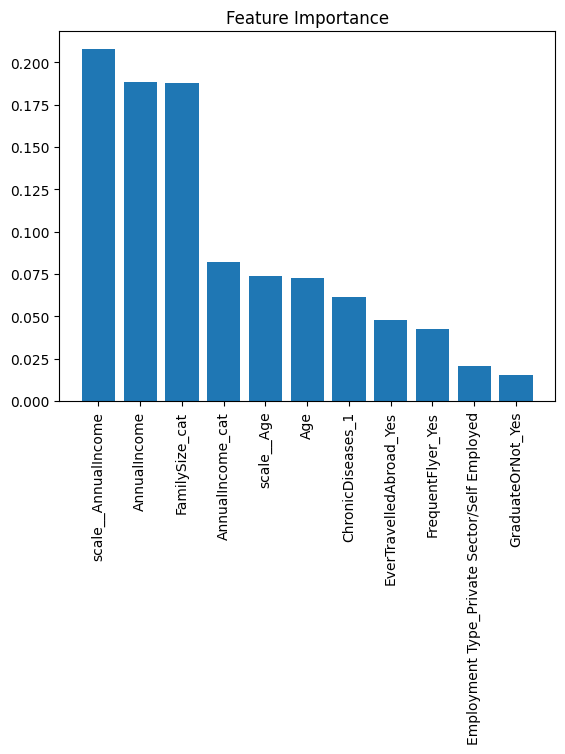

In [39]:
# drop() creates a copy of the data and does not affect train_set
features = df_transformed_train_set.drop("TravelInsurance", axis=1)
labels = df_transformed_train_set["TravelInsurance"].copy()

# Create random forest classifier object
randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train model
rf_model = randomforest.fit(features, labels)

# Calculate feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(features.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(features.shape[1]), names, rotation=90)

# Show plot
plt.show()

It looks like RandomForest are in line with regards to "AnnualIncome" and "FamilySize" features. However, other features such as "TravelledAbroad", "FrequentFlyer" and "Employment Type" seems to be less important features, while "Age" feature gains importance after checking RandomForest suggestions.

Since we don't have that many features and most of them show some potential at explaining the target variable, we will leave all of the features when training our models. 

In [40]:
# Lets drop the original AnnualIncome and Age features since we already have a scaled versions of it
df_transformed_train_set.drop(columns=['Age', 'AnnualIncome'], inplace=True)

In [41]:
df_transformed_train_set.head(2)

,FamilySize_cat,Employment Type_Private Sector/Self Employed,GraduateOrNot_Yes,ChronicDiseases_1,FrequentFlyer_Yes,EverTravelledAbroad_Yes,AnnualIncome_cat,scale__Age,scale__AnnualIncome,TravelInsurance
0,3.00,1.00,1.00,0.00,0.00,0.00,2.00,-0.57,0.70,1.00
1,2.00,1.00,0.00,0.00,1.00,1.00,0.00,0.11,-1.03,0.00


# Modeling

Before we start modelling, we need to recap what is our main objective. 

Our main objective is to correctly identify people who are willing to buy travel insurance and make a sale. 
We want to make sure that we don't skip any customer who might want to get this insurance. 

- In other words, we do care quite much about recall - indentifying as many people as we can that will buy extra travel insurance. So our goal would be to favor models that give good recall score
- However, the higher the recall - the lower the precision. Is low precision costly in this business scenario? Well, not really. This would simply mean that we would be offering travel insurance to people that don't really need one. This doesn't take much effort for a sales person (or algorithm) to ask a customer and it doesn't take to much effort for a customer to say "No" to the extra travel insurance.
- Generally, when we care about recall, a good score to use is roc_auc which measures True positive rate/False positive rate. 
In our case True positive rate (TPR) = from all the customers that want insurance, how many did actually get one? 
False positive rate (FPR) = from all the people that don't want insurance, how many did we still annoy by offering one?
We want our TPR to be as high as possible and FPR as low as possible. So the higher the ROC_AUC, the better is our model for this particular business scenario

In [42]:
# Split the data into features and labels
X = df_transformed_train_set.drop("TravelInsurance", axis=1)
y = df_transformed_train_set["TravelInsurance"].copy()

### Logistic Regression

##### Baseline model

Let's try first with the default model with no tuning just to get a baseline estimation. 

In [43]:
lr_clf = LogisticRegression(random_state=0, class_weight='balanced')
lr_clf.fit(X, y)

# Make predictions on the test set
y_pred = cross_val_predict(lr_clf, X, y, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

# Print the classification report
print("Classification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79      1024
         1.0       0.61      0.62      0.62       565

    accuracy                           0.73      1589
   macro avg       0.70      0.70      0.70      1589
weighted avg       0.73      0.73      0.73      1589


Confusion Matrix:
[[801 223]
 [212 353]]


In [44]:
scores = cross_val_score(lr_clf, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7576712121212121
Standard deviation: 0.1325077897722296


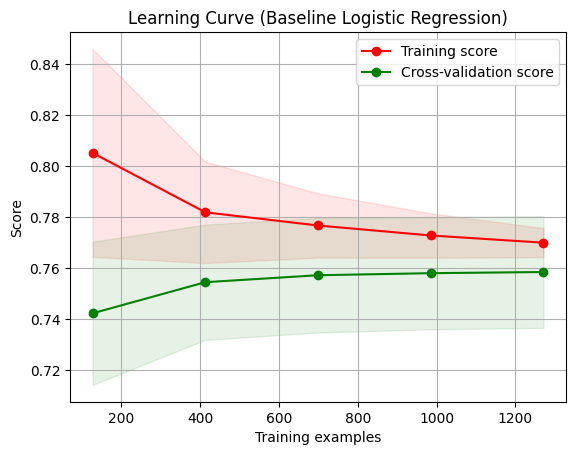

In [45]:
title = "Learning Curve (Baseline Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(lr_clf, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

Our baseline Logistic regression gives recall of 73% with the exact same precision. Our ROC_AUC score for validation datasets (using cross_validation techniques) is about 0.76 with (+-0.02 variance).

It seems that model avoids overfitting the data. This is evident from the plot that shows similar performance in terms of ROC_AUC score for train and validation sets (red and green lines are quite close to each other with more training set sizes)

Its a bit harder to judge if model is underfitting. One indication of underfitting is when both train and validation (red and green) reach a plateau score quickly and doesn't change much with more train data, meaning that our model is just to simple to catch any meaningfull data patterns. In this case, it looks like that validation score keeps improving with more data, but plateaus at around 800 train set size. 

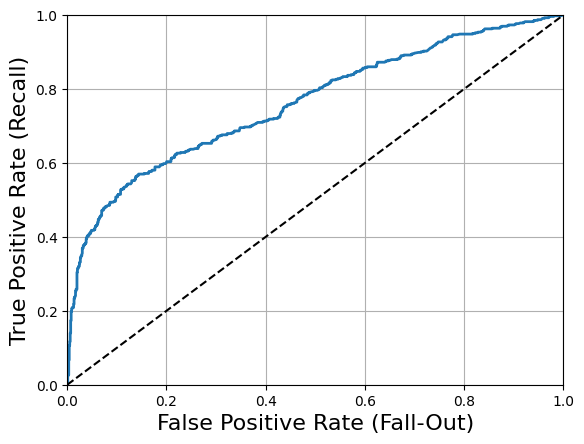

In [46]:
y_scores = cross_val_predict(lr_clf, X, y, cv=3,
                             method="decision_function")

# fpr is false positive rate. false positives / true negatives. 
# shows how many of the negative instances were classified as positive
fpr, tpr, thresholds = roc_curve(y, y_scores)                                      

functions.plot_roc_curve(fpr, tpr, "ROC curve Logistic Regresion")
plt.show()

##### Fine tuned model

In [47]:
lr_clf_tuned = LogisticRegression(class_weight='balanced', random_state=1)

# 'liblinear': Suitable for small datasets. 
# It uses a coordinate descent algorithm and is the default solver for binary logistic regression in scikit-learn.

# 'newton-cg': Uses the Newton-CG conjugate gradient optimization method. 
# It is recommended for small to medium-sized datasets.
param_grid = [
    {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg']}
]

grid_search = GridSearchCV(lr_clf_tuned, param_grid, cv=5,
                           scoring='roc_auc',
                           return_train_score=True,
                           refit=True)

grid_search.fit(X, y)

# Get the best parameters and best model
best_lr_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

In [48]:
best_lr_model

LogisticRegression(C=0.1, class_weight='balanced', random_state=1,
                   solver='newton-cg')

In [49]:
scores = cross_val_score(best_lr_model, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7555621212121211
Standard deviation: 0.13521224905084758


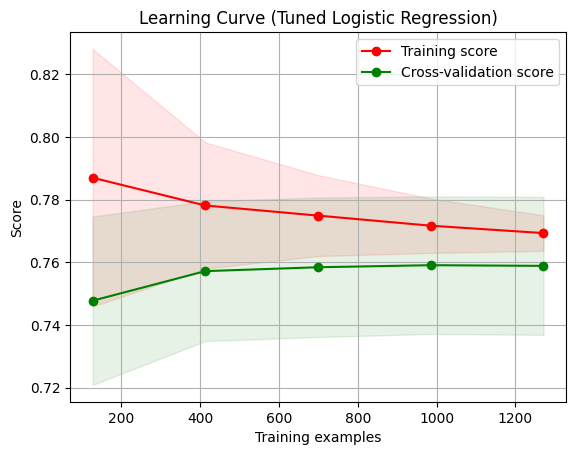

In [50]:
title = "Learning Curve (Tuned Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(best_lr_model, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

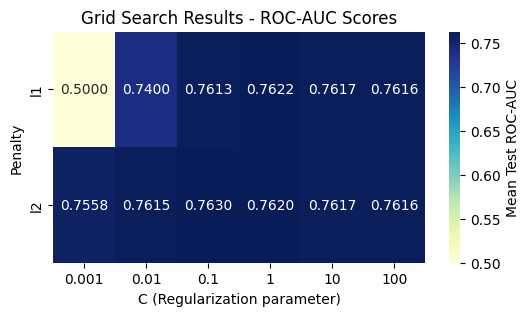

In [51]:
# Access the results
results = pd.DataFrame(grid_search.cv_results_)

# Remove duplicates from the DataFrame
results_no_duplicates = results.drop_duplicates(subset=['param_penalty', 'param_C'])

# Pivot the DataFrame for better visualization
heatmap_data = results_no_duplicates.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test ROC-AUC'})
plt.title("Grid Search Results - ROC-AUC Scores")
plt.xlabel("C (Regularization parameter)")
plt.ylabel("Penalty")
plt.show()

Fine tuned model's average roc_auc score 75.55% seems to be a bit worse than the default model's score 75.76%. Also, the variance of the ROC_AUC is smaller for baseline model 13.25%, compared to the tuned one 13.52%
Both of the models seem to generalize well to validation data. 

In [52]:
best_lr_model = lr_clf

### KNN

##### Baseline model

Let's try the default KNN with no tuning first

In [53]:
# default 
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X, y)

# Make predictions on the test set
y_pred = cross_val_predict(knn_clf, X, y, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

# Print the classification report
print("Classification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85      1024
         1.0       0.77      0.59      0.67       565

    accuracy                           0.79      1589
   macro avg       0.79      0.75      0.76      1589
weighted avg       0.79      0.79      0.79      1589


Confusion Matrix:
[[924 100]
 [229 336]]


In [54]:
scores = cross_val_score(knn_clf, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.764110606060606
Standard deviation: 0.12924216784762663


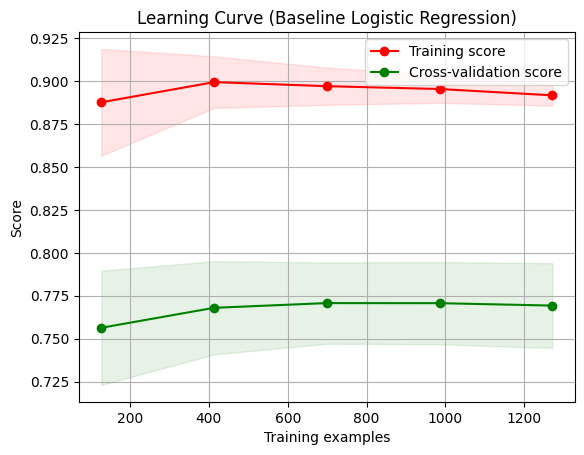

In [55]:
title = "Learning Curve (Baseline Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(knn_clf, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

It looks like default KNN model gives a slightly better ROC_AUC score (0.76) and smaller variance of this score as compared to the default Logistic Regression model. However, we can see from the Learning curves that KNN default model exhibits overfitting tendencies. The gap between the train and validation score is quite large ~(0.9 - 0.77 = 0.13)

##### Fined Tuned Model

In [56]:
# Create a KNN classifier
knn_clf_tuned = KNeighborsClassifier(n_jobs=-1)

# Define the hyperparameters and their possible values to search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'p': [1, 2],  # for Minkowski distance (1 for Manhattan, 2 for Euclidean)
    'weights': ['uniform', 'distance']
}

# Create grid search
# five-fold cross-validation
grid_search_knn = GridSearchCV(knn_clf_tuned, 
                               param_grid, cv=5, 
                               scoring='roc_auc',
                               return_train_score=True,
                               refit=True)

grid_search_knn.fit(X, y)

# Get the best parameters and best model
best_knn_params = grid_search_knn.best_params_
best_knn_model = grid_search_knn.best_estimator_

In [57]:
best_knn_model

KNeighborsClassifier(n_jobs=-1, n_neighbors=11, p=1)

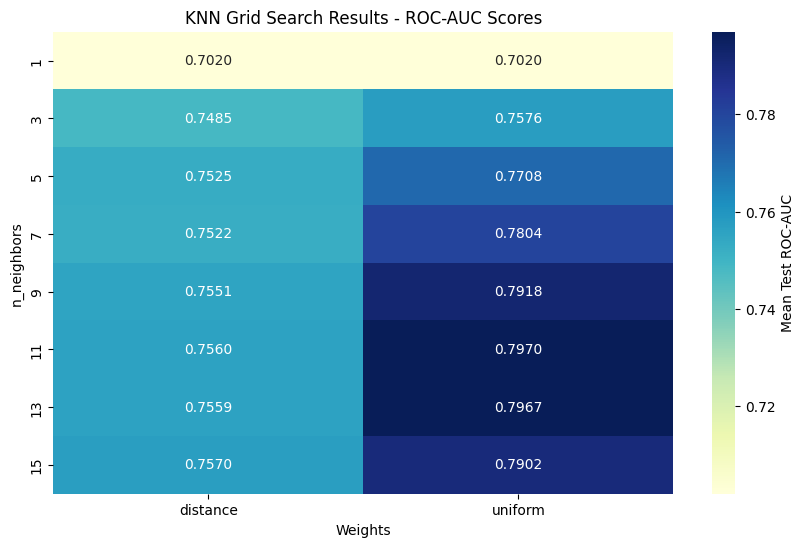

In [58]:
results = pd.DataFrame(grid_search_knn.cv_results_)

# Remove duplicates from the DataFrame
results_no_duplicates = results.drop_duplicates(subset=['param_n_neighbors', 'param_weights'])

# Pivot the DataFrame for better visualization
heatmap_data = results_no_duplicates.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test ROC-AUC'})
plt.title("KNN Grid Search Results - ROC-AUC Scores")
plt.ylabel("n_neighbors")
plt.xlabel("Weights")
plt.show()

In [59]:
scores = cross_val_score(knn_clf_tuned, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.764110606060606
Standard deviation: 0.12924216784762663


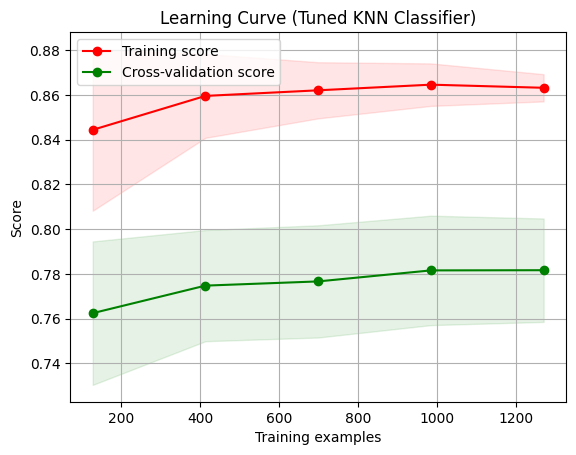

In [60]:
title = "Learning Curve (Tuned KNN Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(best_knn_model, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

It looks like the average score of KNN tuned model did not change at all (still about 0.76), however, now we see from the learning curves plot that the model is overfitting less - the gap between validation and train scores is about 0.08 (0.86 - 0.78) as compared to 0.13 with default KNN model. However, it still a bit too much, so we will try to further reduce model variance and increase bias

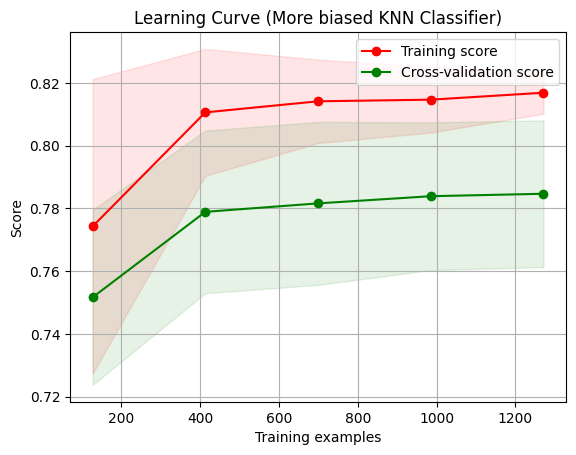

In [61]:
# More biased model. Increase n_neighbors hyperparameter
knn_clf_more_biased = KNeighborsClassifier(n_neighbors=50, p=1, weights='uniform', n_jobs=-1)

title = "Learning Curve (More biased KNN Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(knn_clf_more_biased, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

In [62]:
scores = cross_val_score(knn_clf_more_biased, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.783328787878788
Standard deviation: 0.14464252895423713


With more n_neighbors we do get a smaller overfit as compared to our previous models.The difference between train and test scores is about 0.04. However, the variance of the scores increased a bit from ~0.13 to ~0.14. However, the last model seems to have the best bias and variance trade off and has smaller overfit

In [63]:
best_knn_model = knn_clf_more_biased

### Support Vector Machine

##### Baseline model

In [64]:
# Create support vector classifier
svc_clf = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0)

# Train classifier
model = svc_clf.fit(X, y)

# Make predictions on the test set
y_pred = cross_val_predict(svc_clf, X, y, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

# Print the classification report
print("Classification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1024
         1.0       0.72      0.46      0.56       565

    accuracy                           0.75      1589
   macro avg       0.74      0.68      0.69      1589
weighted avg       0.74      0.75      0.73      1589


Confusion Matrix:
[[925  99]
 [304 261]]


In [65]:
scores = cross_val_score(svc_clf, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7528803030303031
Standard deviation: 0.1395182178121167


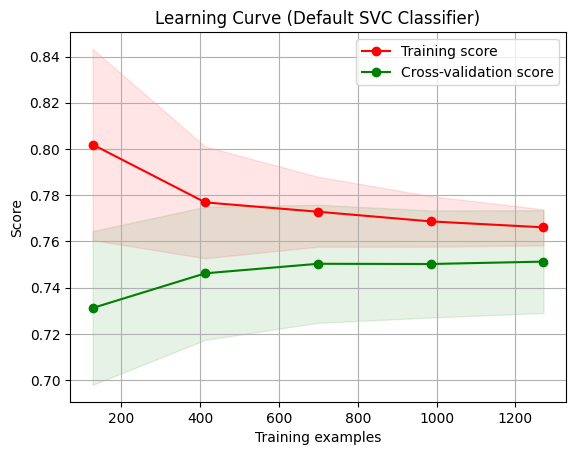

In [66]:
title = "Learning Curve (Default SVC Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(svc_clf, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

Default SVC model seems almost identical in performance as our Default Logistic regression model. Let's not waste to much time and proceed to tune our SCV model. 

##### Fined Tuned model

In [67]:
svc_clf_tuned = SVC(probability=True, class_weight='balanced')  # Set probability to True for ROC-AUC scoring

param_grid = [
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear']}
    # {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1]}
]

# Create grid search
# five-fold cross-validation
grid_search_svc = GridSearchCV(svc_clf_tuned, 
                               param_grid, cv=5, 
                               scoring='roc_auc',
                               return_train_score=True,
                               refit=True)

grid_search_svc.fit(X, y)

# Get the best parameters and best model
best_svc_params = grid_search_svc.best_params_
best_svc_model = grid_search_svc.best_estimator_

In [68]:
best_svc_model

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True)

In [69]:
scores = cross_val_score(best_svc_model, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7535651515151514
Standard deviation: 0.1398908229930312


Let's try to leave C=0.1 and see how 'rbf' model performs

In [70]:
param_grid = {'C': [0.1], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1]}

# Create grid search
# five-fold cross-validation
grid_search_svc = GridSearchCV(svc_clf_tuned, 
                               param_grid, cv=5, 
                               scoring='roc_auc',
                               return_train_score=True,
                               refit=True)

grid_search_svc.fit(X, y)

# Get the best parameters and best model
best_svc_rbf_params = grid_search_svc.best_params_
best_svc_rbf_model = grid_search_svc.best_estimator_

In [71]:
best_svc_rbf_model

SVC(C=0.1, class_weight='balanced', gamma=1, probability=True)

In [72]:
scores = cross_val_score(best_svc_rbf_model, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7806439393939395
Standard deviation: 0.13412975533013527


In [73]:
param_grid = {'C': [0.1], 'kernel': ['poly'], 'degree': [2, 3, 4]}

# Create grid search
# five-fold cross-validation
grid_search_svc = GridSearchCV(svc_clf_tuned, 
                               param_grid, cv=5, 
                               scoring='roc_auc',
                               return_train_score=True,
                               refit=True)

grid_search_svc.fit(X, y)

# Get the best parameters and best model
best_svc_poly_params = grid_search_svc.best_params_
best_svc_poly_model = grid_search_svc.best_estimator_

In [74]:
best_svc_poly_model

SVC(C=0.1, class_weight='balanced', kernel='poly', probability=True)

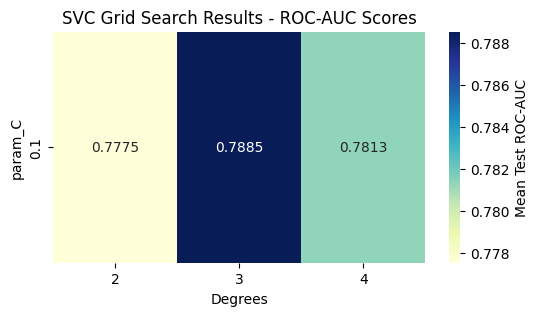

In [75]:
results = pd.DataFrame(grid_search_svc.cv_results_)

# Remove duplicates from the DataFrame
results_no_duplicates = results.drop_duplicates(subset=['param_C', 'param_degree'])

# Pivot the DataFrame for better visualization
heatmap_data = results_no_duplicates.pivot(index='param_C', columns='param_degree', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean Test ROC-AUC'})
plt.title("SVC Grid Search Results - ROC-AUC Scores")
plt.ylabel("param_C")
plt.xlabel("Degrees")
plt.show()

In [76]:
scores = cross_val_score(best_svc_poly_model, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7906530303030305
Standard deviation: 0.1316494281964204


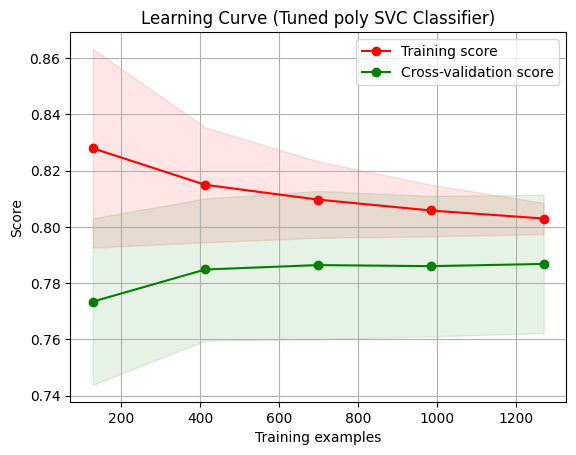

In [77]:
title = "Learning Curve (Tuned poly SVC Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(best_svc_poly_model, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

It looks like the best Support Vector Machine model is a polynomial kernel model with 3 degrees. This model gives 79.06% ROC_AUC score and variance of 13.16%. The learning curves also look nice. Scores for train and validation sets are very close to each other and Scores continue to increase with more training data. 

In [78]:
best_svm_model = best_svc_poly_model

### Random Forests

##### Baseline model

Again we start with a default model without any tunning

In [79]:
# Create random forest classifier object
randomforest_clf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced')

# Train classifier
randomforest_clf.fit(X, y)

# Make predictions on the test set
y_pred = cross_val_predict(randomforest_clf, X, y, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

# Print the classification report
print("Classification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      1024
         1.0       0.69      0.64      0.66       565

    accuracy                           0.77      1589
   macro avg       0.75      0.74      0.75      1589
weighted avg       0.77      0.77      0.77      1589


Confusion Matrix:
[[864 160]
 [204 361]]


In [80]:
scores = cross_val_score(randomforest_clf, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7864863636363637
Standard deviation: 0.13883614301556355


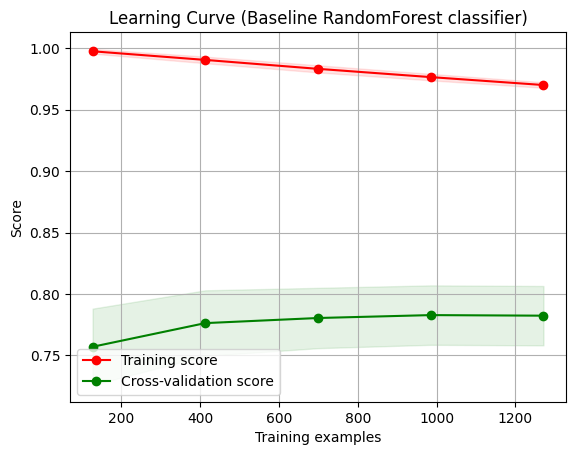

In [81]:
title = "Learning Curve (Baseline RandomForest classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(randomforest_clf, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

Its is quite evident from the learning curve that our RandomForest model overfits the data, since our score is very good on train set, but is significantly lower for validation set. Thus, we need to proceed with model tuning

##### Fine Tuned Model

In [82]:
randomforest_clf_tuned = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True],  # Method for sampling data points with or without replacement
    'criterion': ['gini']  # Function to measure the quality of a split
}

# Create grid search
# five-fold cross-validation
grid_search_rf = GridSearchCV(randomforest_clf_tuned, 
                               param_grid, cv=5, 
                               scoring='roc_auc',
                               return_train_score=True,
                               refit=True)

grid_search_rf.fit(X, y)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=0),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc')

In [83]:
# Get the best parameters and best model
best_rf_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

In [84]:
best_rf_model

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, n_jobs=-1, random_state=0)

In [85]:
results = pd.DataFrame(grid_search_rf.cv_results_)
results[(results['param_max_depth'] == 10) & 
        (results['param_min_samples_leaf'] == 2) &
        (results['param_min_samples_split'] == 10) & 
        (results['param_n_estimators'] == 50)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
69,0.09,0.00,0.03,0.00,True,gini,10,sqrt,2,10,...,0.80,0.01,1,0.92,0.92,0.92,0.92,0.92,0.92,0.00
96,0.10,0.00,0.03,0.00,True,gini,10,log2,2,10,...,0.80,0.01,1,0.92,0.92,0.92,0.92,0.92,0.92,0.00


In [86]:
scores = cross_val_score(best_rf_model, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7922378787878788
Standard deviation: 0.13658658349593764


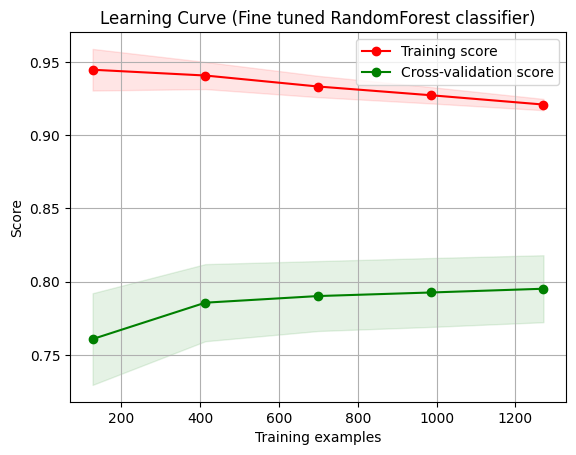

In [87]:
title = "Learning Curve (Fine tuned RandomForest classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(best_rf_model, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

It looks like our Random forest model is a bit too overfitted. Let's change some hyperparameters to see if we can address this problem

In [88]:
randomforest_clf_less_overfit = RandomForestClassifier(class_weight='balanced', 
                    max_depth=4,
                    max_features='sqrt',
                    min_samples_leaf=2, 
                    min_samples_split=10,
                    n_estimators=50, 
                    n_jobs=-1, 
                    random_state=0, 
                    bootstrap=True)

randomforest_clf_less_overfit.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50, n_jobs=-1,
                       random_state=0)

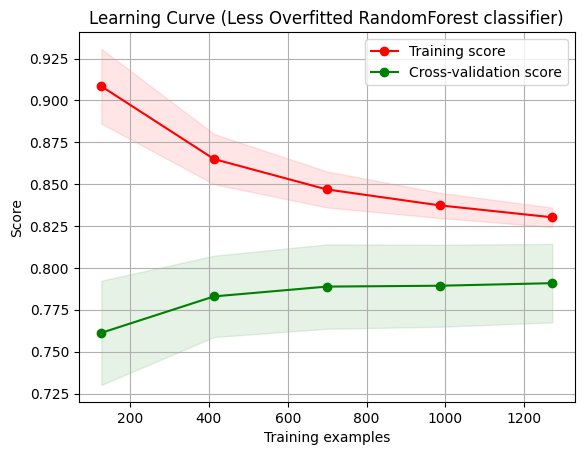

In [89]:
title = "Learning Curve (Less Overfitted RandomForest classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

functions.plot_learning_curve(randomforest_clf_less_overfit, title, X, y, cv=cv, n_jobs=-1, scoring='roc_auc')
plt.show()

In [90]:
scores = cross_val_score(randomforest_clf_less_overfit, X, y, scoring="roc_auc", 
                         cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

functions.display_scores(scores)

Mean: 0.7921984848484849
Standard deviation: 0.13779353923868445


It looks like the best Random Forest model is where max_depth is set to as small (max_depth=4) as possible (without sacrificing too much the score on validation set). This model gives 79.21% ROC_AUC score and variance of 13.77%. The learning curves also look nice. Scores for train and validation sets are very close to each other and Scores continue to increase with more training data. 

In [91]:
best_rf_model = randomforest_clf_less_overfit

### Recap of our best models so far...

In [92]:
# Put all of our best models' performance numbers in a dataframe

data = {
    'Model': ['LogisticRegression (Baseline)', 'LogisticRegression (Fine Tuned)', 'KNN (Baseline)', 'KNN (Fine Tuned)',
              'SVM (Baseline)', 'SVM (Fine Tuned)', 'RandomForest (Baseline)', 'RandomForest (Fine Tuned)'],
    'Mean': [0.7577, 0.7556, 0.7641, 0.7833, 0.7529, 0.7907, 0.7865, 0.7922],
    'Std Dev': [0.1325, 0.1352, 0.1292, 0.1446, 0.1395, 0.1316, 0.1388, 0.1378],
    'Overfit': ['No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No']
}

# Set display precision for floating-point numbers
pd.set_option('display.float_format', '{:.4f}'.format)

model_performance_df = pd.DataFrame(data)

# Show 4 best models based on mean ROC_AUC score
df_best_models = model_performance_df[model_performance_df['Overfit'] == 'No'].sort_values(by='Mean', 
                                                                                          ascending=False)[:4]
# create columns where we will put precision and recall of our best models
df_best_models['Weighted Average Precision'] = np.nan
df_best_models['Weighted Average Recall'] = np.nan

In [93]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Place precision and recall figures in our dataframe
best_models = [best_rf_model, best_svm_model, best_knn_model, best_lr_model]

for id, model in enumerate(best_models):
    # Make predictions on the test set
    y_pred = cross_val_predict(model, X, y, cv=StratifiedKFold(n_splits=100, shuffle=True, random_state=42))

    # Parse the classification report to get precision, recall, and f1-score
    precision, recall, fscore, support = precision_recall_fscore_support(y, y_pred, average='weighted')

    df_best_models.iloc[id, 4] = precision
    df_best_models.iloc[id, 5] = recall
    

In [94]:
df_best_models = df_best_models.rename(columns={'Mean': 'ROC_AUC'})
df_best_models

,Model,ROC_AUC,Std Dev,Overfit,Weighted Average Precision,Weighted Average Recall
7,RandomForest (Fine Tuned),0.7922,0.1378,No,0.8324,0.8232
5,SVM (Fine Tuned),0.7907,0.1316,No,0.8204,0.8162
3,KNN (Fine Tuned),0.7833,0.1446,No,0.8241,0.8106
0,LogisticRegression (Baseline),0.7577,0.1325,No,0.7275,0.7262


Our best model so far is a fine tuned RandomForest model achieving 79% of ROC_AUC score. Aslo it has the best numbers when it comes to Recall, which is what we want to see for this business problem. 

Next let's use one of the ensemble techniques to achieve even a better performance. 

### Ensemble. Voting Classifier 

In [95]:
# Create a VotingClassifier with Logistic Regression and KNN
voting_classifier = VotingClassifier(estimators=[
    ('logistic', best_lr_model),
    ('knn', best_knn_model),
    ('svm', best_svm_model),
    ('forest', best_rf_model)
], voting='soft')

cv = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)
y_pred = cross_val_predict(voting_classifier, X, y, cv=cv)
precision, recall, fscore, support = precision_recall_fscore_support(y, y_pred, average='weighted')

# Perform cross-validation with ROC AUC scoring
roc_auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
cv_scores_roc_auc = cross_val_score(voting_classifier, X, y, cv=cv, scoring=roc_auc_scorer)

# Display cross-validation ROC AUC scores
print("Mean ROC AUC:", cv_scores_roc_auc.mean())
print(f"precision: {precision}") 
print(f"recall: {recall}") 

Mean ROC AUC: 0.78915
precision: 0.8265048245065827
recall: 0.8181246066708622


Actually, compared to our best performing RandomForest Model, Voting classifier performs worse.

### Model decision!

Based on all of our models the fine tuned Random Forest model performed the best achieving below performance measures:

ROC_AUC: 79.22%
ROC_AUC Std Dev: 13.78%	
Weighted Average Precision: 83.24%
Weighted Average Recall: 82.32%

# Testing

In [96]:
transformed_test_set = full_pipeline.transform(test_set)

# Get the column names after each transformation
column_names = full_pipeline.get_feature_names_out()

# Create a DataFrame with the transformed data and column names
df_transformed_test_set = pd.DataFrame(transformed_test_set, columns=column_names)

# Remove the common prefix "text__" from all column names except for "scale__"
df_transformed_test_set.columns = df_transformed_test_set.columns.str.replace('ord__', '')
df_transformed_test_set.columns = df_transformed_test_set.columns.str.replace('cat__', '')
df_transformed_test_set.columns = df_transformed_test_set.columns.str.replace('income_', '')
df_transformed_test_set.columns = df_transformed_test_set.columns.str.replace('remainder__', '')

# Lets drop the original AnnualIncome and Age features since we already have a scaled versions of it
df_transformed_test_set.drop(columns=['Age', 'AnnualIncome'], inplace=True)

df_transformed_test_set.head(2)

,FamilySize_cat,Employment Type_Private Sector/Self Employed,GraduateOrNot_Yes,ChronicDiseases_1,FrequentFlyer_Yes,EverTravelledAbroad_Yes,AnnualIncome_cat,scale__Age,scale__AnnualIncome,TravelInsurance
0,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,-0.5694,-0.6343,0.0000
1,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.1142,-1.0346,0.0000


In [97]:
# Split the data into features and labels
X_test = df_transformed_test_set.drop("TravelInsurance", axis=1)
y_test = df_transformed_test_set["TravelInsurance"].copy()


In [98]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)
y_probs = best_rf_model.predict_proba(X_test)[:, 1] # prob of positive class

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Adjust the threshold (e.g., set a new threshold of 0.3)
new_threshold = 0.37
y_pred_adjusted = (y_probs >= new_threshold).astype(int)

# Evaluate the model with the adjusted threshold
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
classification_rep = classification_report(y_test, y_pred_adjusted)

print("\nClassification Report (threshold 0.37):\n", classification_rep)
print("Confusion Matrix (threshold 0.37):\n", conf_matrix)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88       253
         1.0       0.92      0.61      0.74       145

    accuracy                           0.84       398
   macro avg       0.87      0.79      0.81       398
weighted avg       0.85      0.84      0.83       398


Confusion Matrix:
[[245   8]
 [ 56  89]]

Classification Report (threshold 0.37):
               precision    recall  f1-score   support

         0.0       0.83      0.79      0.81       253
         1.0       0.66      0.72      0.69       145

    accuracy                           0.76       398
   macro avg       0.75      0.76      0.75       398
weighted avg       0.77      0.76      0.77       398

Confusion Matrix (threshold 0.37):
 [[199  54]
 [ 40 105]]


# Launch model?

### Hypothesis test for recall

In [99]:
from statsmodels.stats.proportion import proportions_ztest

# Your null hypothesis recall value
null_hypothesis_recall = 0.6

# Your single recall value
observed_recall = 0.84

# test sample size 
sample_size = 398

# Number of successes (true positives)
successes = int(observed_recall * sample_size)  # Assuming sample_size is the total number of instances

# Number of trials (total instances)
trials = sample_size

# Perform one-sample proportions test
stat, p_value = proportions_ztest(successes, trials, value=null_hypothesis_recall)

# Output the results
print(f'Z-statistic: {stat}')
print(f'P-value: {p_value}')

# Compare p-value to significance level
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis. Recall is significantly different from 0.6.')
else:
    print('Fail to reject the null hypothesis. Not enough evidence to claim a significant difference.')


Z-statistic: 12.990182843185893
P-value: 1.390943580462071e-38
Reject the null hypothesis. Recall is significantly different from 0.6.


### Model's potential to solve a business problem

By looking at our final test, we see that test results (first "Classification Report" above) are very good and are not worse than our scores received during training. 

To put it into perspective of our business problem, let's examine what these numbers mean with some examples:
- If we had 145 people visiting our travel agency all willing to buy travel insurance, we would only make an offer to 89 of them (61%)
- Once we decide to actually make an offer for travel insurance, we would be 92% precise.
- if we had 253 people visiting our travel agency all unwilling to take on travel insurance, we would be almost certain (97%) that these people don't want travel insurance and we would not even make an offer to them.
- Once we decide that it is not worth to bother a customer, we would be 81% precise. 

The main number that we are most interested in is, unfortunately, the lowest. We are talking about Recall of 61% for people that are willing to buy insurance. This means that we would fail to make some extra money from 39% of our customers that really want travel insurance. However, if we look at all the customers, we see that there are many more people that don't want insurance as compared to the ones that do. Thus, it might be ok to let those customers go. 

If travel insurance is offered by a human sales person, then precision could matter more. If we have a lot of false positives, that means that sales person is waisting time offering insurance to people that don't want it instead of servicing other customers. If this is, indeed, an issue, then having higher precision for positive cases is also important as having a high recall. 

However, if travel insurance is offered by an algorithm in an travel website, then we might get away with lower precision (person would just click "No" on the offer). In this case, we want to increase recall for positive cases (model identifying correctly people who really want travel insurance) at the expense of offering more insurance to people that don't need it. 
Thus, for high recall, low precision case, we could simply set a lower probability threshold (second "Classification Report" above). Meaning that if model outputs probability of 1.0 (positive) case of, say, 0.4, model would still classify it as positive outcome (person wants insurance). 

# Conclusions

- Best performing, Random Forest Regression, model achieved 79% ROC_SCORE, >80% recall and precision
- Recall for positive labels (individuals that want travel insurance) was 61% on test set
- Combined Recall for all labels was 84%. 
- If every customer matters, then we should look at 61% recall. If not - 84% recall is more appropriate
- If wasting time offering insurance to people that do not want it is costly for business, then this model is a good fit. However, if we want to make as many sales as possible, then we would need to adjust the probability threshold of the model. In other words, if probability of positive label is 0.4, the instance would still be marked as positive. A threshold of 0.37 seemed to be a good candidate. 
- Ensemble Voting Classifier surprisingly underperformed Random Forest Regression model


# Limitations

- Small dataset
- Feature engineering part could be expanded to construct more features out of the dataset
- More time could be spend on ensemble training methods to find one that performs better than an individual model
- No information about a reference model that can be used for a proper model hypothesis test